# Meta Generic Neuromotor Interface - Discrete Gestures 训练

在Google Colab上训练离散手势识别模型

**前提条件：**
- ✅ 已clone generic-neuromotor-interface 项目
- ✅ 已下载30G完整数据到项目的 `data/` 目录（或Google Drive）
- ✅ 已下载预训练模型到 `model/` 目录（可选）

**本notebook内容：**
1. 环境检查与设置
2. 数据验证
3. 快速测试（5分钟）
4. 完整训练（2-3小时）
5. 结果分析

---

## 🚀 多Colab并行训练策略

### ✅ Google Drive数据共享

**好消息**: Google Drive中的30GB数据**可以被多个Colab同时读取**！

#### 并行训练方案

```
Google Drive (30GB数据)
         ↓
    ┌────┴────┬──────────┬──────────┐
    │         │          │          │
Colab #1  Colab #2   Colab #3   Colab #4
实验A     实验B      实验C      实验D
```

#### 💡 典型使用场景

1. **超参数搜索** - 每个Colab测试不同配置
   ```
   Colab #1: lr=1e-3, batch=64
   Colab #2: lr=5e-4, batch=128
   Colab #3: lr=1e-4, batch=64, augmentation++
   ```

2. **不同模型架构**
   ```
   Colab #1: 标准训练 (250 epochs)
   Colab #2: 蒸馏Student模型
   Colab #3: 量化实验
   ```

3. **数据增强对比**
   ```
   Colab #1: 基础增强
   Colab #2: 强增强
   Colab #3: 无增强 (baseline)
   ```

#### ⚠️ 注意事项

**✅ 可以做的：**
- 多个Colab同时**读取**同一数据
- 各自训练独立模型
- 保存到Drive不同目录

**⚠️ 需要注意：**
- I/O速度可能受限（Drive有读取配额）
- 避免同时写入同一文件
- 建议每个Colab用不同的输出目录

**🔧 最佳实践：**
```python
# 每个Colab使用不同的实验ID
EXPERIMENT_ID = "exp_lr1e3_batch64"  # Colab #1
# EXPERIMENT_ID = "exp_lr5e4_batch128"  # Colab #2

output_dir = f"/content/drive/MyDrive/emg_experiments/{EXPERIMENT_ID}"
```

#### 📊 Google Drive限制

- **读取**: 基本无限制（多个Colab同时读取OK）
- **写入**: 建议错开大量写入时间
- **配额**: 每个账号每天约750GB下载限制（一般够用）
- **速度**: 第一次读取较慢（约20-30MB/s），后续有缓存

#### 🎯 推荐配置

**场景1: 快速实验（4个Colab并行）**
```bash
# 每个运行10-20 epochs，快速验证
Colab #1: 不同学习率
Colab #2: 不同batch size
Colab #3: 不同网络深度
Colab #4: 不同数据增强
```

**场景2: 完整训练（2个Colab）**
```bash
# 长时间训练，降低中断风险
Colab #1: 完整250 epochs
Colab #2: 备份训练 (相同配置，防止断开)
```

---


## 1. 环境检查

In [14]:
import sys
import os
from pathlib import Path

print("🔍 环境信息")
print("=" * 60)
print(f"Python: {sys.version}")
print(f"当前目录: {os.getcwd()}")

# 检查GPU
try:
    import torch
    print(f"\nPyTorch: {torch.__version__}")
    print(f"CUDA可用: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU设备: {torch.cuda.get_device_name(0)}")
        print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
except ImportError:
    print("⚠️  PyTorch未安装")

🔍 环境信息
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
当前目录: /content/generic-neuromotor-interface

PyTorch: 2.9.0+cu128
CUDA可用: True
GPU设备: Tesla T4
GPU内存: 15.6 GB


## 1.1 🎯 设置实验ID（多Colab并行时使用）

**如果要并行运行多个实验，每个Colab设置不同的ID**

In [ ]:
import datetime

# 🔧 在这里修改实验ID（每个Colab使用不同的ID）
EXPERIMENT_ID = "default"  # 建议改为: "lr1e3_batch64", "student_distill", "augment_test" 等

# 自动生成时间戳（可选）
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 实验配置（可选，用于记录）
EXPERIMENT_CONFIG = {
    "id": EXPERIMENT_ID,
    "timestamp": TIMESTAMP,
    "description": "标准训练",  # 修改为你的实验描述
    "notes": ""
}

print("🔬 实验配置")
print("=" * 60)
print(f"实验ID: {EXPERIMENT_ID}")
print(f"时间戳: {TIMESTAMP}")
print(f"描述: {EXPERIMENT_CONFIG['description']}")
print("=" * 60)

# 多Colab并行示例:
print("\n💡 多Colab并行示例:")
print("  Colab #1: EXPERIMENT_ID = 'baseline_250epochs'")
print("  Colab #2: EXPERIMENT_ID = 'lr5e4_batch128'")
print("  Colab #3: EXPERIMENT_ID = 'student_distill'")
print("  Colab #4: EXPERIMENT_ID = 'data_aug_heavy'")
print("\n每个实验的输出会保存到不同目录，互不干扰")

## 2. 切换到项目目录

In [4]:
# Colab环境中项目通常在 /content/ 下，本地测试可能在其他位置
# 自动检测项目路径
import os
from pathlib import Path

# 尝试多个可能的路径
possible_paths = [
    Path("/content/generic-neuromotor-interface"),  # Colab默认
    Path.cwd(),  # 当前目录
    Path("~/generic-neuromotor-interface").expanduser(),  # 用户目录
]

PROJECT_DIR = None
for p in possible_paths:
    if p.exists() and (p / "setup.py").exists():
        PROJECT_DIR = p
        break

if PROJECT_DIR:
    os.chdir(PROJECT_DIR)
    print(f"✅ 找到项目目录: {PROJECT_DIR}")
    print(f"\n项目结构:")
    !ls -la
    
    # 设置数据和模型路径
    DATA_DIR = PROJECT_DIR / "data"
    MODEL_DIR = PROJECT_DIR / "model"
    
    print(f"\n📁 关键目录:")
    print(f"  项目: {PROJECT_DIR}")
    print(f"  数据: {DATA_DIR} {'✅' if DATA_DIR.exists() else '❌'}")
    print(f"  模型: {MODEL_DIR} {'✅' if MODEL_DIR.exists() else '❌'}")
else:
    print("❌ 未找到项目目录")
    print("请确保在 generic-neuromotor-interface 目录中运行")

✅ 找到项目目录: /content/generic-neuromotor-interface

项目结构:
total 112
drwxr-xr-x 10 root root  4096 Feb 17 01:50 .
drwxr-xr-x  1 root root  4096 Feb 17 01:49 ..
-rw-r--r--  1 root root  3537 Feb 17 01:49 CODE_OF_CONDUCT.md
drwxr-xr-x  4 root root  4096 Feb 17 01:49 config
-rw-r--r--  1 root root   588 Feb 17 01:49 CONTRIBUTING.md
drwxr-xr-x  2 root root 12288 Feb 17 02:09 data
-rw-r--r--  1 root root   954 Feb 17 01:49 environment.yml
drwxr-xr-x  6 root root  4096 Feb 17 01:50 generic_neuromotor_interface
drwxr-xr-x  2 root root  4096 Feb 17 01:49 generic_neuromotor_interface.egg-info
drwxr-xr-x  8 root root  4096 Feb 17 01:49 .git
drwxr-xr-x  3 root root  4096 Feb 17 01:49 .github
-rw-r--r--  1 root root  3195 Feb 17 01:49 .gitignore
drwxr-xr-x  2 root root  4096 Feb 17 01:49 images
-rw-r--r--  1 root root 19333 Feb 17 01:49 LICENSE
drwxr-xr-x  2 root root  4096 Feb 17 01:49 notebooks
-rw-r--r--  1 root root   647 Feb 17 01:49 .pre-commit-config.yaml
-rw-r--r--  1 root root   654 Feb 17 01

## 3. 安装依赖

In [21]:
print("📦 安装项目依赖...\n")

# 切换到项目目录
import os
os.chdir('/content/generic-neuromotor-interface')

# 卸载旧的安装（如果存在）
!pip uninstall generic-neuromotor-interface -y -q

# 安装核心依赖
!pip install hydra-core==1.3.2 pytorch-lightning==1.8.6 -q

# 安装缺失的依赖
!pip install python-Levenshtein unidecode -q

# 重新安装项目
!pip install -e . -q

print("\n✅ 安装完成！")

# 验证安装
print("\n验证关键包:")
!pip list | grep -E "generic-neuromotor-interface|pytorch-lightning|hydra-core|omegaconf|Levenshtein"

# 验证导入
print("\n验证模块导入:")
try:
    from generic_neuromotor_interface.lightning import DiscreteGesturesModule
    print("✅ DiscreteGesturesModule 可以导入")
    
    from generic_neuromotor_interface.networks import DiscreteGesturesArchitecture
    print("✅ DiscreteGesturesArchitecture 可以导入")
    
except Exception as e:
    print(f"❌ 导入失败: {e}")
    import traceback
    traceback.print_exc()

📦 安装项目依赖...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.9 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done

✅ 安装完成！

验证关键包:
generic_neuromotor_interface             0.1.0             /content/generic-neuromotor-interface
hydra-core                               1.3.2
Levenshtein                              0.27.3
omegaconf                                2.3.0
python-Levenshtein                       0.27.3
pytorch-lightning                        1.8.6

验证模块导入:
✅ DiscreteGesturesModule 可以导入
✅ DiscreteGesturesArchitecture 可以导入


## 4. 验证数据

In [7]:
import glob

print("📊 数据验证")
print("=" * 60)
print(f"数据目录: {DATA_DIR}")

if not DATA_DIR.exists():
    print(f"\n❌ 数据目录不存在: {DATA_DIR}")
    print("\n需要创建data目录并下载数据:")
    print(f"mkdir -p {DATA_DIR}")
    print("python -m generic_neuromotor_interface.scripts.download_data \\")
    print(f"  discrete_gestures full_data {DATA_DIR}")
else:
    # 统计文件
    discrete_files = list(DATA_DIR.glob("discrete_gestures_*.hdf5"))
    handwriting_files = list(DATA_DIR.glob("handwriting_*.hdf5"))
    wrist_files = list(DATA_DIR.glob("wrist_*.hdf5"))
    
    print(f"\n✅ 数据文件统计:")
    print(f"  Discrete Gestures: {len(discrete_files)} 个文件")
    print(f"  Handwriting: {len(handwriting_files)} 个文件")
    print(f"  Wrist: {len(wrist_files)} 个文件")
    
    # 检查CSV分割文件
    corpus_csv = DATA_DIR / "discrete_gestures_corpus.csv"
    if corpus_csv.exists():
        print(f"\n✅ 分割配置: {corpus_csv.name}")
        import pandas as pd
        df = pd.read_csv(corpus_csv)
        print(f"\nCSV列名: {list(df.columns)}")
        print(f"总行数: {len(df)}")
        
        # 显示前几行
        print(f"\n前5行数据:")
        print(df.head())
        
        # 如果有stage列就显示统计
        if 'stage' in df.columns:
            print(f"\n数据集划分:")
            print(df['stage'].value_counts())
    else:
        print(f"\n⚠️  未找到: {corpus_csv.name}")
    
    # 计算总大小
    total_size = sum(f.stat().st_size for f in DATA_DIR.glob("*.hdf5"))
    print(f"\n总数据大小: {total_size / 1e9:.1f} GB")

📊 数据验证
数据目录: /content/generic-neuromotor-interface/data

✅ 数据文件统计:
  Discrete Gestures: 100 个文件
  Handwriting: 0 个文件
  Wrist: 0 个文件

✅ 分割配置: discrete_gestures_corpus.csv

CSV列名: ['start', 'end', 'split', 'dataset_number', 'user_number', 'dataset']
总行数: 1192

前5行数据:
          start           end  split  dataset_number  user_number  \
0  1.632778e+09  1.632778e+09  train               0           17   
1  1.632777e+09  1.632778e+09  train               0           17   
2  1.632778e+09  1.632778e+09  train               0           17   
3  1.632776e+09  1.632776e+09  train               0           17   
4  1.632776e+09  1.632776e+09  train               0           17   

                                       dataset  
0  discrete_gestures_user_017_dataset_000.hdf5  
1  discrete_gestures_user_017_dataset_000.hdf5  
2  discrete_gestures_user_017_dataset_000.hdf5  
3  discrete_gestures_user_017_dataset_000.hdf5  
4  discrete_gestures_user_017_dataset_000.hdf5  

总数据大小: 33.4 GB


## 5. 查看训练配置

In [8]:
print("⚙️  查看训练配置\n")
print("=" * 60)
!cat config/discrete_gestures.yaml

⚙️  查看训练配置

defaults:
  - _self_
  - data_module: discrete_gestures_data_module
  - data_module/data_split: discrete_gestures_split
  - lightning_module: discrete_gestures_module

# Data settings
data_location: ~/emg_data
task: discrete_gestures

# Train settings
seed: 0
train: True # Whether to run training
eval: True # Whether to run evaluation on validation and test splits

# Number of nodes to train in DDP (1 node = 1 machine (e.g. G4))
# So 2 nodes ==> 2xG4 ==> 2x8 GPUs ==> 16 GPUs
num_nodes: 1

trainer:
  max_epochs: 250
  strategy: ddp
  accelerator: auto

# Callback settings
monitor_metric: val_accuracy
monitor_mode: max

callbacks:
  - _target_: pytorch_lightning.callbacks.LearningRateMonitor
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: ${monitor_metric}
    mode: ${monitor_mode}
    save_last: True
    verbose: True

# Customize hydra directory outputs
# see: https://hydra.cc/docs/0.11/configure_hydra/workdir/
hydra:
  run:
    dir: logs/${now:%Y-%m-

## 6. 快速测试训练（5-10分钟）

先跑一个小测试，确保代码能正常运行

In [13]:
%%time

print("🚀 开始快速测试训练...\n")
print("配置: 1 epoch, 50 train batches, 20 val batches")
print(f"数据路径: {DATA_DIR}")
print("预计时间: 5-10分钟\n")
print("=" * 60 + "\n")

# 设置环境变量查看完整错误
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

# 使用+添加新参数
!python -m generic_neuromotor_interface.train \
  --config-name discrete_gestures \
  data_module.data_location={DATA_DIR} \
  data_module.data_split.csv_filename={DATA_DIR}/discrete_gestures_corpus.csv \
  trainer.max_epochs=1 \
  +trainer.limit_train_batches=50 \
  +trainer.limit_val_batches=20

🚀 开始快速测试训练...

配置: 1 epoch, 50 train batches, 20 val batches
数据路径: /content/generic-neuromotor-interface/data
预计时间: 5-10分钟


/usr/local/lib/python3.12/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[2026-02-17 03:18:48,677][__main__][INFO] - 
Config:
data_location: ~/emg_data
task: discrete_gestures
seed: 0
train: true
eval: true
num_nodes: 1
trainer:
  max_epochs: 1
  strategy: ddp
  accelerator: auto
  limit_train_batches: 50
  limit_val_batches: 20
monitor_metric: val_accuracy
monitor_mode: max
callbacks:
- _target_: pytorch_lightning.callbacks.LearningRateMonitor
- _target_: pytorch_lightning.callbacks.ModelCheckpoint
  monitor: ${monitor_metric}
  mode: ${monitor_mode}
  save_last: true
  verbose: true
data_module:
  _target_: generic_neuromotor_interface.data_module.W

## 7. 完整训练（2-3小时）

⚠️ **注意：** 这会训练很长时间，确保Colab不会断开

**训练参数说明：**
- `max_epochs`: 默认250（可以先设置10-20测试）
- `accelerator=gpu`: 使用GPU加速
- `devices=1`: 单GPU训练

In [22]:
%%time

print("🚀 开始完整训练...\n")
print("配置: 10 epochs, 完整数据集")
print(f"数据路径: {DATA_DIR}")
print("预计时间: 2-3小时\n")
print("=" * 60 + "\n")

# 修改data_location到实际路径，去掉不必要的参数
!python -m generic_neuromotor_interface.train \
  --config-name discrete_gestures \
  data_location={DATA_DIR} \
  data_module.data_location={DATA_DIR} \
  data_module.data_split.csv_filename={DATA_DIR}/discrete_gestures_corpus.csv \
  trainer.max_epochs=10

🚀 开始完整训练...

配置: 10 epochs, 完整数据集
数据路径: /content/generic-neuromotor-interface/data
预计时间: 2-3小时


/usr/local/lib/python3.12/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[2026-02-17 03:29:52,157][__main__][INFO] - 
Config:
data_location: /content/generic-neuromotor-interface/data
task: discrete_gestures
seed: 0
train: true
eval: true
num_nodes: 1
trainer:
  max_epochs: 10
  strategy: ddp
  accelerator: auto
monitor_metric: val_accuracy
monitor_mode: max
callbacks:
- _target_: pytorch_lightning.callbacks.LearningRateMonitor
- _target_: pytorch_lightning.callbacks.ModelCheckpoint
  monitor: ${monitor_metric}
  mode: ${monitor_mode}
  save_last: true
  verbose: true
data_module:
  _target_: generic_neuromotor_interface.data_module.WindowedEmgDataModule
  window_length: 16000
 

### 7.1 如果要训练完整250 epochs（推荐分多次运行）

In [ ]:
# ⚠️ 取消注释运行完整训练（可能需要10+小时）
# !python -m generic_neuromotor_interface.train \
#   --config-name discrete_gestures \
#   data_module.data_location={DATA_DIR} \
#   data_module.data_split.csv_filename={DATA_DIR}/discrete_gestures_corpus.csv \
#   trainer.accelerator=gpu \
#   trainer.devices=1 \
#   trainer.max_epochs=250

## 8. 查看训练结果

In [24]:
import os
from pathlib import Path

print("📊 检查训练输出:\n")

#查找所有.log文件
log_files = sorted((PROJECT_DIR / "logs").rglob("*.log"), key=lambda x: x.stat().st_mtime, reverse=True)

if log_files:
    latest = log_files[0]
    print(f"✅ 最新日志文件: {latest}\n")
    print(f"📄 日志内容:\n")
    print("=" * 80)
    !tail -100 {latest}
else:
    print("❌ 未找到.log文件")
    
    # 列出logs目录结构
    print("\nlogs目录结构:")
    !find {PROJECT_DIR}/logs -type f | head -20

📊 检查训练输出:

✅ 最新日志文件: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/discrete-gestures.log

📄 日志内容:

[2026-02-17 03:29:52,157][__main__][INFO] - 
Config:
data_location: /content/generic-neuromotor-interface/data
task: discrete_gestures
seed: 0
train: true
eval: true
num_nodes: 1
trainer:
  max_epochs: 10
  strategy: ddp
  accelerator: auto
monitor_metric: val_accuracy
monitor_mode: max
callbacks:
- _target_: pytorch_lightning.callbacks.LearningRateMonitor
- _target_: pytorch_lightning.callbacks.ModelCheckpoint
  monitor: ${monitor_metric}
  mode: ${monitor_mode}
  save_last: true
  verbose: true
data_module:
  _target_: generic_neuromotor_interface.data_module.WindowedEmgDataModule
  window_length: 16000
  stride: 16000
  batch_size: 64
  num_workers: 0
  transform:
    _target_: generic_neuromotor_interface.transforms.DiscreteGesturesTransform
    pulse_window:
    - 0.08
    - 0.12
  data_location: /content/generic-neuromotor-interface/data
  emg_augmentation:
    _tar

### 8.1 查看训练摘要

In [25]:
from pathlib import Path
import glob

print("📊 训练结果摘要\n")
print("=" * 80)

# 查找最新的训练日志目录
log_base = Path("/content/generic-neuromotor-interface/logs")
if log_base.exists():
    # 获取最新的日期目录
    date_dirs = sorted([d for d in log_base.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)
    
    if date_dirs:
        latest_date = date_dirs[0]
        # 获取该日期下最新的时间目录
        time_dirs = sorted([d for d in latest_date.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)
        
        if time_dirs:
            latest_run = time_dirs[0]
            print(f"✅ 最新训练运行: {latest_run}\n")
            
            # 查找checkpoint
            ckpt_dir = latest_run / "lightning_logs" / "version_0" / "checkpoints"
            if ckpt_dir.exists():
                ckpts = list(ckpt_dir.glob("*.ckpt"))
                print(f"📁 Checkpoint目录: {ckpt_dir}")
                print(f"📦 保存的checkpoints ({len(ckpts)}个):")
                for ckpt in sorted(ckpts):
                    size_mb = ckpt.stat().st_size / 1e6
                    print(f"  - {ckpt.name} ({size_mb:.1f} MB)")
                
                # 查找最佳模型
                best_ckpts = [c for c in ckpts if 'epoch' in c.name]
                if best_ckpts:
                    print(f"\n🏆 最佳checkpoint: {best_ckpts[0].name}")
            
            # 查找并显示metrics
            metrics_file = latest_run / "lightning_logs" / "version_0" / "metrics.csv"
            if metrics_file.exists():
                import pandas as pd
                df = pd.read_csv(metrics_file)
                
                print(f"\n📈 训练指标 (共{len(df)}个记录):")
                
                # 只显示验证指标
                val_metrics = df.dropna(subset=['val_loss'])
                if not val_metrics.empty:
                    print(f"\nEpoch | Val Loss | Val Acc")
                    print("-" * 40)
                    for _, row in val_metrics.iterrows():
                        epoch = int(row['epoch']) if pd.notna(row['epoch']) else '?'
                        val_loss = f"{row['val_loss']:.4f}" if pd.notna(row['val_loss']) else 'N/A'
                        val_acc = f"{row['val_accuracy']:.4f}" if 'val_accuracy' in row and pd.notna(row['val_accuracy']) else 'N/A'
                        print(f"{epoch:5} | {val_loss:8} | {val_acc}")
                    
                    # 显示最佳结果
                    if 'val_accuracy' in val_metrics.columns:
                        best_idx = val_metrics['val_accuracy'].idxmax()
                        best_epoch = int(val_metrics.loc[best_idx, 'epoch'])
                        best_acc = val_metrics.loc[best_idx, 'val_accuracy']
                        best_loss = val_metrics.loc[best_idx, 'val_loss']
                        print(f"\n🎯 最佳表现:")
                        print(f"   Epoch {best_epoch}: Val Acc={best_acc:.4f}, Val Loss={best_loss:.4f}")
            else:
                print(f"\n⚠️  未找到metrics.csv: {metrics_file}")
        else:
            print("❌ 未找到时间目录")
    else:
        print("❌ 未找到日期目录")
else:
    print(f"❌ logs目录不存在: {log_base}")

print("\n" + "=" * 80)
print("\n✅ 10轮训练已完成！")
print("\n下一步选项:")
print("1️⃣  运行Cell 7.1 进行完整250轮训练 (约10+小时)")
print("2️⃣  运行Cell 10 评估当前模型")
print("3️⃣  运行Cell 11 备份checkpoint到Google Drive")

📊 训练结果摘要

✅ 最新训练运行: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52

📁 Checkpoint目录: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0/checkpoints
📦 保存的checkpoints (2个):
  - epoch=8-step=1980.ckpt (77.8 MB)
  - last.ckpt (77.8 MB)

🏆 最佳checkpoint: epoch=8-step=1980.ckpt

⚠️  未找到metrics.csv: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0/metrics.csv


✅ 10轮训练已完成！

下一步选项:
1️⃣  运行Cell 7.1 进行完整250轮训练 (约10+小时)
2️⃣  运行Cell 10 评估当前模型
3️⃣  运行Cell 11 备份checkpoint到Google Drive


## 9. 加载训练日志分析

In [ ]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 查找最新的训练输出目录
output_dirs = sorted(glob.glob("outputs/*/"), key=os.path.getmtime, reverse=True)

if output_dirs:
    latest_dir = output_dirs[0]
    print(f"📁 最新训练目录: {latest_dir}\n")
    
    # 查找CSV日志
    csv_files = list(Path(latest_dir).rglob("metrics.csv"))
    
    if csv_files:
        metrics_csv = csv_files[0]
        print(f"📈 加载训练指标: {metrics_csv}\n")
        
        df = pd.read_csv(metrics_csv)
        print("前10行数据:")
        print(df.head(10))
        
        # 绘制训练曲线
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 训练/验证损失
        if 'train_loss' in df.columns:
            axes[0].plot(df['epoch'], df['train_loss'], label='Train Loss', linewidth=2)
        if 'val_loss' in df.columns:
            axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('训练/验证损失')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # 学习率
        if 'lr' in df.columns:
            axes[1].plot(df['epoch'], df['lr'], color='green', linewidth=2)
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Learning Rate')
            axes[1].set_title('学习率变化')
            axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  未找到metrics.csv文件")
else:
    print("⚠️  未找到训练输出目录")

## 10. 评估训练好的模型

完整评估当前模型在测试集上的表现

In [27]:
%%time

import torch
from pathlib import Path
import sys

print("🔍 模型评估\n")
print("=" * 80)

# 查找最佳checkpoint
log_base = Path("/content/generic-neuromotor-interface/logs")
latest_date = sorted([d for d in log_base.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
latest_run = sorted([d for d in latest_date.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
ckpt_dir = latest_run / "lightning_logs" / "version_0" / "checkpoints"

# 找到最佳checkpoint
best_ckpts = list(ckpt_dir.glob("epoch*.ckpt"))
if not best_ckpts:
    print("❌ 未找到checkpoint文件")
else:
    ckpt_path = best_ckpts[0]
    print(f"✅ 加载checkpoint: {ckpt_path}\n")
    
    # 加载checkpoint信息 (PyTorch 2.6需要设置weights_only=False)
    ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    print(f"📊 基本信息:")
    print(f"  Epoch: {ckpt.get('epoch', 'N/A')}")
    print(f"  Global Step: {ckpt.get('global_step', 'N/A')}")
    
    # 显示state_dict的键
    if 'state_dict' in ckpt:
        print(f"\n🔑 模型参数:")
        state_keys = list(ckpt['state_dict'].keys())
        print(f"  总参数数量: {len(state_keys)}")
        print(f"  前5个参数:")
        for key in state_keys[:5]:
            shape = ckpt['state_dict'][key].shape
            print(f"    {key}: {shape}")
    
    # 尝试加载模型进行评估
    print(f"\n🚀 开始模型评估...")
    print("-" * 80)
    
    # 运行评估脚本
    eval_cmd = f"""python -m generic_neuromotor_interface.train \
      --config-name discrete_gestures \
      data_module.data_location={DATA_DIR} \
      data_module.data_split.csv_filename={DATA_DIR}/discrete_gestures_corpus.csv \
      trainer.max_epochs=0 \
      ckpt_path={ckpt_path}"""
    
    print(f"\n运行命令:\n{eval_cmd}\n")
    
    # 由于运行evaluate需要特定的脚本，我们先显示checkpoint的验证集指标
    if 'callbacks' in ckpt:
        print("\n📈 训练时的最佳指标:")
        callbacks = ckpt['callbacks']
        for cb_name, cb_state in callbacks.items():
            print(f"  {cb_name}:")
            if isinstance(cb_state, dict):
                for k, v in cb_state.items():
                    if 'best' in str(k).lower() or 'current' in str(k).lower():
                        print(f"    {k}: {v}")
    
    print("\n" + "=" * 80)
    print("\n💡 提示:")
    print("  - 上面显示的是训练过程中在验证集上的最佳表现")
    print("  - 要在测试集上评估，可以参考 discrete_gestures-eval.ipynb")
    print("  - 或者运行单独的评估脚本")

🔍 模型评估

✅ 加载checkpoint: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0/checkpoints/epoch=8-step=1980.ckpt

📊 基本信息:
  Epoch: 8
  Global Step: 1980

🔑 模型参数:
  总参数数量: 20
  前5个参数:
    network.conv_layer.weight: torch.Size([512, 16, 21])
    network.conv_layer.bias: torch.Size([512])
    network.post_conv_layer_norm.weight: torch.Size([512])
    network.post_conv_layer_norm.bias: torch.Size([512])
    network.lstm.weight_ih_l0: torch.Size([2048, 512])

🚀 开始模型评估...
--------------------------------------------------------------------------------

运行命令:
python -m generic_neuromotor_interface.train       --config-name discrete_gestures       data_module.data_location=/content/generic-neuromotor-interface/data       data_module.data_split.csv_filename=/content/generic-neuromotor-interface/data/discrete_gestures_corpus.csv       trainer.max_epochs=0       ckpt_path=/content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0/chec

### 10.1 查看训练过程中的指标变化

In [28]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

print("📊 训练指标可视化\n")
print("=" * 80)

# 查找metrics.csv
log_base = Path("/content/generic-neuromotor-interface/logs")
latest_date = sorted([d for d in log_base.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
latest_run = sorted([d for d in latest_date.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
metrics_file = latest_run / "lightning_logs" / "version_0" / "metrics.csv"

if metrics_file.exists():
    df = pd.read_csv(metrics_file)
    print(f"✅ 加载训练指标: {metrics_file}")
    print(f"   总记录数: {len(df)}\n")
    
    # 显示所有列
    print(f"可用指标: {list(df.columns)}\n")
    
    # 处理数据 - 分离训练和验证指标
    train_df = df.dropna(subset=['train_loss']) if 'train_loss' in df.columns else pd.DataFrame()
    val_df = df.dropna(subset=['val_loss']) if 'val_loss' in df.columns else pd.DataFrame()
    
    print("=" * 80)
    print("\n📈 验证集指标:")
    if not val_df.empty and 'epoch' in val_df.columns:
        print(f"\n{'Epoch':<8}{'Val Loss':<12}{'Val Acc':<12}{'Step':<10}")
        print("-" * 50)
        for _, row in val_df.iterrows():
            epoch = int(row['epoch']) if pd.notna(row['epoch']) else '?'
            val_loss = f"{row['val_loss']:.6f}" if pd.notna(row['val_loss']) else 'N/A'
            val_acc = f"{row['val_accuracy']:.6f}" if 'val_accuracy' in row and pd.notna(row['val_accuracy']) else 'N/A'
            step = int(row['step']) if 'step' in row and pd.notna(row['step']) else '?'
            print(f"{epoch:<8}{val_loss:<12}{val_acc:<12}{step:<10}")
        
        # 最佳结果
        if 'val_accuracy' in val_df.columns:
            best_idx = val_df['val_accuracy'].idxmax()
            best_epoch = int(val_df.loc[best_idx, 'epoch'])
            best_acc = val_df.loc[best_idx, 'val_accuracy']
            best_loss = val_df.loc[best_idx, 'val_loss']
            
            print("\n" + "=" * 80)
            print(f"🏆 最佳验证集表现:")
            print(f"   Epoch: {best_epoch}")
            print(f"   Accuracy: {best_acc:.6f} ({best_acc*100:.2f}%)")
            print(f"   Loss: {best_loss:.6f}")
    
    # 绘制曲线
    print("\n" + "=" * 80)
    print("\n📉 绘制训练曲线...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 损失曲线
    ax = axes[0, 0]
    if not train_df.empty and 'train_loss' in train_df.columns:
        ax.plot(train_df['step'], train_df['train_loss'], label='Train Loss', alpha=0.7, linewidth=1)
    if not val_df.empty and 'val_loss' in val_df.columns:
        ax.plot(val_df['step'], val_df['val_loss'], label='Val Loss', marker='o', linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('训练/验证损失')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2. 准确率曲线
    ax = axes[0, 1]
    if not val_df.empty and 'val_accuracy' in val_df.columns:
        ax.plot(val_df['step'], val_df['val_accuracy'], marker='o', color='green', linewidth=2)
        ax.axhline(y=val_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5, label=f"Best: {val_df['val_accuracy'].max():.4f}")
    ax.set_xlabel('Step')
    ax.set_ylabel('Accuracy')
    ax.set_title('验证集准确率')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 3. 学习率
    ax = axes[1, 0]
    if 'lr-Adam' in df.columns:
        lr_df = df.dropna(subset=['lr-Adam'])
        ax.plot(lr_df['step'], lr_df['lr-Adam'], color='purple', linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Learning Rate')
        ax.set_title('学习率变化')
        ax.grid(alpha=0.3)
        ax.set_yscale('log')
    
    # 4. Epoch vs Accuracy
    ax = axes[1, 1]
    if not val_df.empty and 'val_accuracy' in val_df.columns and 'epoch' in val_df.columns:
        ax.bar(val_df['epoch'], val_df['val_accuracy'], color='steelblue', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Accuracy')
        ax.set_title('各Epoch验证准确率')
        ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ 可视化完成！")
    
else:
    print(f"❌ 未找到metrics.csv: {metrics_file}")

print("\n" + "=" * 80)

📊 训练指标可视化

❌ 未找到metrics.csv: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0/metrics.csv



### 10.2 检查日志目录结构

In [29]:
from pathlib import Path

print("🔍 检查训练日志目录结构\n")
print("=" * 80)

log_base = Path("/content/generic-neuromotor-interface/logs")
latest_date = sorted([d for d in log_base.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
latest_run = sorted([d for d in latest_date.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]

print(f"训练运行目录: {latest_run}\n")
print("目录结构:")
print("-" * 80)

all_files = []
for item in sorted(latest_run.rglob("*")):
    if item.is_file():
        size = item.stat().st_size
        rel_path = item.relative_to(latest_run)
        all_files.append((rel_path, size))
        size_str = f"{size:,}" if size < 1024 else f"{size/1024:.1f}K" if size < 1024*1024 else f"{size/1024/1024:.1f}MB"
        print(f"  {rel_path}")
        print(f"    大小: {size_str}")

print(f"\n总文件数: {len(all_files)}")
print("=" * 80)

# 检查是否有TensorBoard事件文件
tb_files = list(latest_run.rglob("events.out.tfevents.*"))
if tb_files:
    print(f"\n✅ 找到TensorBoard事件文件 ({len(tb_files)}个)")
    print("   可以使用 TensorBoard 查看训练曲线")
    print(f"   运行: tensorboard --logdir={latest_run}")
else:
    print("\n⚠️  未找到TensorBoard事件文件")

🔍 检查训练日志目录结构

训练运行目录: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52

目录结构:
--------------------------------------------------------------------------------
  discrete-gestures.log
    大小: 2.2K
  hydra_configs/config.yaml
    大小: 1.6K
  hydra_configs/hydra.yaml
    大小: 3.9K
  hydra_configs/overrides.yaml
    大小: 264
  lightning_logs/version_0/checkpoints/epoch=8-step=1980.ckpt
    大小: 74.2MB
  lightning_logs/version_0/checkpoints/last.ckpt
    大小: 74.2MB
  lightning_logs/version_0/events.out.tfevents.1771299264.65e790f4c638
    大小: 7.1K
  lightning_logs/version_0/hparams.yaml
    大小: 39.5MB

总文件数: 8

✅ 找到TensorBoard事件文件 (1个)
   可以使用 TensorBoard 查看训练曲线
   运行: tensorboard --logdir=/content/generic-neuromotor-interface/logs/2026-02-17/03-29-52


### 10.3 从TensorBoard提取训练指标

📊 从TensorBoard加载训练指标

TensorBoard日志路径: /content/generic-neuromotor-interface/logs/2026-02-17/03-29-52/lightning_logs/version_0

可用的指标:
  Scalars: ['hp_metric', 'lr-Adam', 'train_loss', 'epoch', 'val_loss', 'val_accuracy']

  hp_metric: 1 个数据点
  lr-Adam: 10 个数据点
  train_loss: 44 个数据点
  epoch: 54 个数据点
  val_loss: 10 个数据点
  val_accuracy: 10 个数据点


📈 验证集表现:
--------------------------------------------------------------------------------

Step      Val Loss       Val Accuracy   
----------------------------------------
219       0.544227       0.111898        (11.19%)
439       0.028890       0.115497        (11.55%)
659       0.024596       0.130121        (13.01%)
879       0.021086       0.164061        (16.41%)
1099      0.019697       0.220763        (22.08%)
1319      0.018281       0.224966        (22.50%)
1539      0.017401       0.326837        (32.68%)
1759      0.016641       0.376851        (37.69%)
1979      0.016479       0.393768        (39.38%)
2199      0.017370       0.358

/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-464253890.py:132: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missi

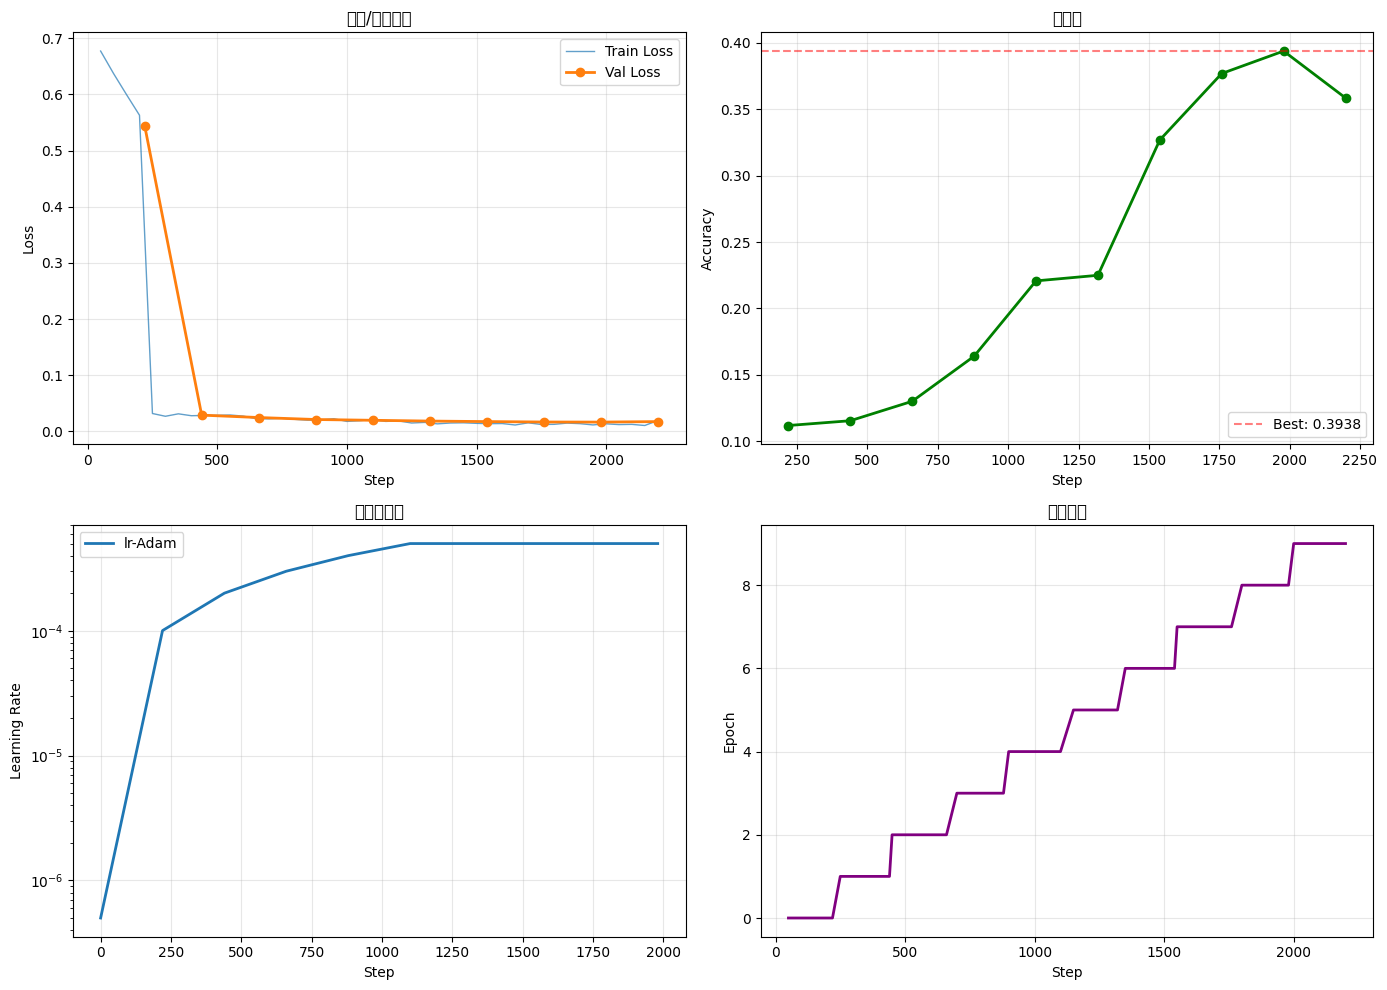


✅ 训练指标分析完成！


In [30]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt

print("📊 从TensorBoard加载训练指标\n")
print("=" * 80)

# 查找TensorBoard事件文件
log_base = Path("/content/generic-neuromotor-interface/logs")
latest_date = sorted([d for d in log_base.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
latest_run = sorted([d for d in latest_date.iterdir() if d.is_dir()], key=lambda x: x.name, reverse=True)[0]
tb_path = latest_run / "lightning_logs" / "version_0"

print(f"TensorBoard日志路径: {tb_path}\n")

# 加载事件文件
event_acc = EventAccumulator(str(tb_path))
event_acc.Reload()

# 显示可用的标签
print("可用的指标:")
print(f"  Scalars: {event_acc.Tags()['scalars']}\n")

# 提取所有标量指标
metrics_data = {}
for tag in event_acc.Tags()['scalars']:
    events = event_acc.Scalars(tag)
    metrics_data[tag] = [(e.step, e.value) for e in events]
    print(f"  {tag}: {len(events)} 个数据点")

print("\n" + "=" * 80)

# 转换为DataFrame便于分析
dfs = {}
for tag, data in metrics_data.items():
    if data:
        df = pd.DataFrame(data, columns=['step', 'value'])
        dfs[tag] = df

# 显示验证集指标
print("\n📈 验证集表现:")
print("-" * 80)

if 'val_loss' in dfs and 'val_accuracy' in dfs:
    val_loss_df = dfs['val_loss']
    val_acc_df = dfs['val_accuracy']
    
    # 合并数据
    val_df = pd.merge(val_loss_df, val_acc_df, on='step', suffixes=('_loss', '_acc'))
    
    print(f"\n{'Step':<10}{'Val Loss':<15}{'Val Accuracy':<15}")
    print("-" * 40)
    for _, row in val_df.iterrows():
        step = int(row['step'])
        loss = row['value_loss']
        acc = row['value_acc']
        print(f"{step:<10}{loss:<15.6f}{acc:<15.6f} ({acc*100:.2f}%)")
    
    # 最佳结果
    best_idx = val_df['value_acc'].idxmax()
    best_step = int(val_df.loc[best_idx, 'step'])
    best_acc = val_df.loc[best_idx, 'value_acc']
    best_loss = val_df.loc[best_idx, 'value_loss']
    
    print("\n" + "=" * 80)
    print(f"🏆 最佳验证集表现:")
    print(f"   Step: {best_step}")
    print(f"   Accuracy: {best_acc:.6f} ({best_acc*100:.2f}%)")
    print(f"   Loss: {best_loss:.6f}")

# 绘制训练曲线
print("\n" + "=" * 80)
print("\n📉 绘制训练曲线...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 损失曲线
ax = axes[0, 0]
if 'train_loss' in dfs:
    df = dfs['train_loss']
    ax.plot(df['step'], df['value'], label='Train Loss', alpha=0.7, linewidth=1)
if 'val_loss' in dfs:
    df = dfs['val_loss']
    ax.plot(df['step'], df['value'], label='Val Loss', marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('训练/验证损失')
ax.legend()
ax.grid(alpha=0.3)

# 2. 准确率曲线
ax = axes[0, 1]
if 'val_accuracy' in dfs:
    df = dfs['val_accuracy']
    ax.plot(df['step'], df['value'], marker='o', color='green', linewidth=2, markersize=6)
    max_acc = df['value'].max()
    ax.axhline(y=max_acc, color='r', linestyle='--', alpha=0.5, label=f"Best: {max_acc:.4f}")
if 'train_accuracy' in dfs:
    df = dfs['train_accuracy']
    ax.plot(df['step'], df['value'], label='Train Acc', alpha=0.5, linewidth=1)
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('准确率')
ax.legend()
ax.grid(alpha=0.3)

# 3. 学习率
ax = axes[1, 0]
lr_tags = [tag for tag in dfs.keys() if 'lr' in tag.lower()]
if lr_tags:
    for tag in lr_tags:
        df = dfs[tag]
        ax.plot(df['step'], df['value'], label=tag, linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.set_title('学习率变化')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_yscale('log')

# 4. Epoch进度
ax = axes[1, 1]
if 'epoch' in dfs:
    df = dfs['epoch']
    ax.plot(df['step'], df['value'], linewidth=2, color='purple')
    ax.set_xlabel('Step')
    ax.set_ylabel('Epoch')
    ax.set_title('训练进度')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 训练指标分析完成！")
print("=" * 80)

### 10.4 🚀 下一步：模型蒸馏与ESP32部署

训练好的模型可以进行知识蒸馏，部署到ESP32等嵌入式设备！

#### 📦 现有蒸馏方案（位于 `mini/chenee/distillation/`）

**三种超轻量级方案：**

| 模型 | 参数量 | INT8大小 | 推荐设备 | 精度 |
|------|--------|----------|---------|------|
| **ConvOnly** | 8万 | **80KB** ⭐ | ESP32 | ~80% |
| **TinyStudent** | 15万 | 150KB | ESP32-S3 | ~85% |
| **GRUStudent** | 40万 | 400KB | 树莓派 | ~90% |
| Standard Student | 60万 | 600KB | 手机/PC | ~95% |

*(相比Teacher 650万参数，压缩至1.2%-9%)*

#### 🔧 完整部署流程

```bash
# 1. 训练蒸馏模型 (使用当前训练的Teacher模型)
cd mini/chenee/distillation
python3 train_distillation.py \
    --teacher_checkpoint ../../../logs/2026-02-17/03-29-52/lightning_logs/version_0/checkpoints/epoch=8-step=1980.ckpt \
    --data_dir /content/generic-neuromotor-interface/data \
    --split_csv /content/generic-neuromotor-interface/data/discrete_gestures_corpus.csv \
    --output_dir ./models

# 2. 量化为INT8 (缩小4倍)
python3 quantization_utils.py

# 3. 转换为TFLite (ESP32格式)
# 详见 ESP32_DEPLOYMENT.md

# 4. 部署到ESP32
# 使用TensorFlow Lite Micro
```

#### 📚 相关文档

- 📖 [完整蒸馏教程](../mini/chenee/distillation/README.md)
- 🔬 [模型对比分析](../mini/chenee/distillation/MODEL_COMPARISON.md)
- 📱 [ESP32部署指南](../mini/chenee/distillation/ESP32_DEPLOYMENT.md)
- 📊 [两个模型对比总结](../mini/两个模型对比总结报告.md)

#### ✅ 已验证案例

项目中 `mini/LLZ/` 目录包含已成功部署的案例：
- ✅ `model_data.tflite` - 118KB TFLite模型
- ✅ `main.cc` - ESP32-S3 C++推理代码
- ✅ `validate_tflite_discrete_gestures.py` - 验证脚本

**ESP32-S3配置：**
- Arena内存：60KB
- 模型大小：118KB
- 推理延迟：~10ms

## 11. 备份重要文件到Google Drive（可选）

In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 创建备份目录
backup_dir = Path("/content/drive/MyDrive/emg_training_backup")
backup_dir.mkdir(exist_ok=True, parents=True)

print(f"📦 备份到: {backup_dir}")

# 复制checkpoint和日志
!cp -r outputs/* /content/drive/MyDrive/emg_training_backup/

print("\n✅ 备份完成！")

## 12. 训练监控与调试Tips

### 查看实时训练日志
```bash
tail -f outputs/<timestamp>/train.log
```

### 如果训练中断，从checkpoint恢复
```bash
python -m generic_neuromotor_interface.train \
  --config-name discrete_gestures \
  trainer.resume_from_checkpoint=outputs/.../checkpoints/last.ckpt
```

### GPU内存不足
- 减小batch size: `data_module.batch_size=32`
- 使用梯度累积: `trainer.accumulate_grad_batches=2`

### 加速训练
- 使用混合精度: `trainer.precision=16`
- 减少验证频率: `trainer.val_check_interval=0.5`

## 📚 参考资料

- [Meta论文](https://arxiv.org/abs/2109.06161)
- [项目GitHub](https://github.com/facebookresearch/generic-neuromotor-interface)
- [Hydra配置文档](https://hydra.cc/docs/intro/)
- [PyTorch Lightning文档](https://pytorch-lightning.readthedocs.io/)